## Recurrent Neural Network (RNN) Model

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tensorflow_addons.metrics import RSquare
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Activation, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

We start by loading in the dataframe that was created in the EDA notebook

In [6]:
df = pd.read_csv('../data/NSRDB_to_model.csv')

In [35]:
df.head()

,datetime,Wind_x,Wind_y,Dew Point,Cloud Type,Day Seasonality,Year Seasonality,Pressure,Relative Humidity,Temperature,Solar Zenith Angle,GHI
0,2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
1,2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2,2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
3,2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
4,2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0


## Standard RNN Model

Next we define the features. 'Cloud Type' is a special case, as it is a categorical variable that should be one hot encoded

In [7]:
num_features = ['Wind_x', 'Wind_y', 'Dew Point', 'Day Seasonality', 'Year Seasonality', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']
cloudtypes = to_categorical(df['Cloud Type'])

We will scale 'GHI' with a separate standardscaler, so that we can easily transform model outputs back with this particular scaler. The cloudtypes dont have to be scaled, as they are one-hot-encoded with the to_categorical function

In [8]:
stacked_data = np.hstack([df[num_features].values])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(stacked_data)
ss_y = StandardScaler() #using a separate transformer for GHI so I can easily transform back afterwards
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

Next, I need to split the data into the right sequences that I can feed to the RNN model. I would like to use the data of the previous 4 days (48 x 4 = 192 timesteps) to predict the next day (48 timesteps).
The split sequence function below was adapted from: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [58]:
def split_sequences(data_in, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(data_in.shape[0]):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > data_in.shape[0]:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data_in[i:end_ix, :-1], data_in[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# choose a number of time steps 
n_steps_in, n_steps_out = 192, 48

X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

The X data now is a 3-D array, with shape: (observations, n_steps_in, features) <br>
the y data is a 2-D array with shape: (observations, n_steps_out) <br>
Now we can train test split, which we can simply do by slicing the array:

In [54]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 19), (62400, 48), (25058, 192, 19), (25058, 48))

In [59]:
#working model
lstm_model = Sequential()
lstm_model.add(LSTM(32,return_sequences=True, input_shape=(n_steps_in, nr_features)))
lstm_model.add(Dropout(0.03))
lstm_model.add(LSTM(16))

lstm_model.add(Dense(n_steps_out))

In [60]:
#optimizer learning rate
opt = Nadam(learning_rate=0.001)

es = EarlyStopping(patience=5)
lstm_model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [61]:
history = lstm_model.fit(train_X , train_y, batch_size=1200, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
52/52 [==============================] - 22s 382ms/step - loss: 0.9420 - r_square: 0.0681 - val_loss: 0.7583 - val_r_square: 0.2246
Epoch 2/90
52/52 [==============================] - 18s 353ms/step - loss: 0.6083 - r_square: 0.3982 - val_loss: 0.4219 - val_r_square: 0.5686
Epoch 3/90
52/52 [==============================] - 18s 349ms/step - loss: 0.3660 - r_square: 0.6379 - val_loss: 0.2937 - val_r_square: 0.6996
Epoch 4/90
52/52 [==============================] - 18s 350ms/step - loss: 0.2799 - r_square: 0.7231 - val_loss: 0.2308 - val_r_square: 0.7640
Epoch 5/90
52/52 [==============================] - 18s 346ms/step - loss: 0.2260 - r_square: 0.7764 - val_loss: 0.1876 - val_r_square: 0.8082
Epoch 6/90
52/52 [==============================] - 18s 350ms/step - loss: 0.1865 - r_square: 0.8155 - val_loss: 0.1563 - val_r_square: 0.8402
Epoch 7/90
52/52 [==============================] - 18s 347ms/step - loss: 0.1572 - r_square: 0.8445 - val_loss: 0.1342 - val_r_square: 0.8627

In [88]:
preds_train = lstm_model.predict(train_X)
preds_test = lstm_model.predict(test_X)

784/784 [==============================] - 14s 17ms/step


In [89]:
test_y_ghi = ss_y.inverse_transform(test_y)
preds_test_ghi = ss_y.inverse_transform(preds_test)
train_y_ghi = ss_y.inverse_transform(train_y)
preds_train_ghi = ss_y.inverse_transform(preds_train)

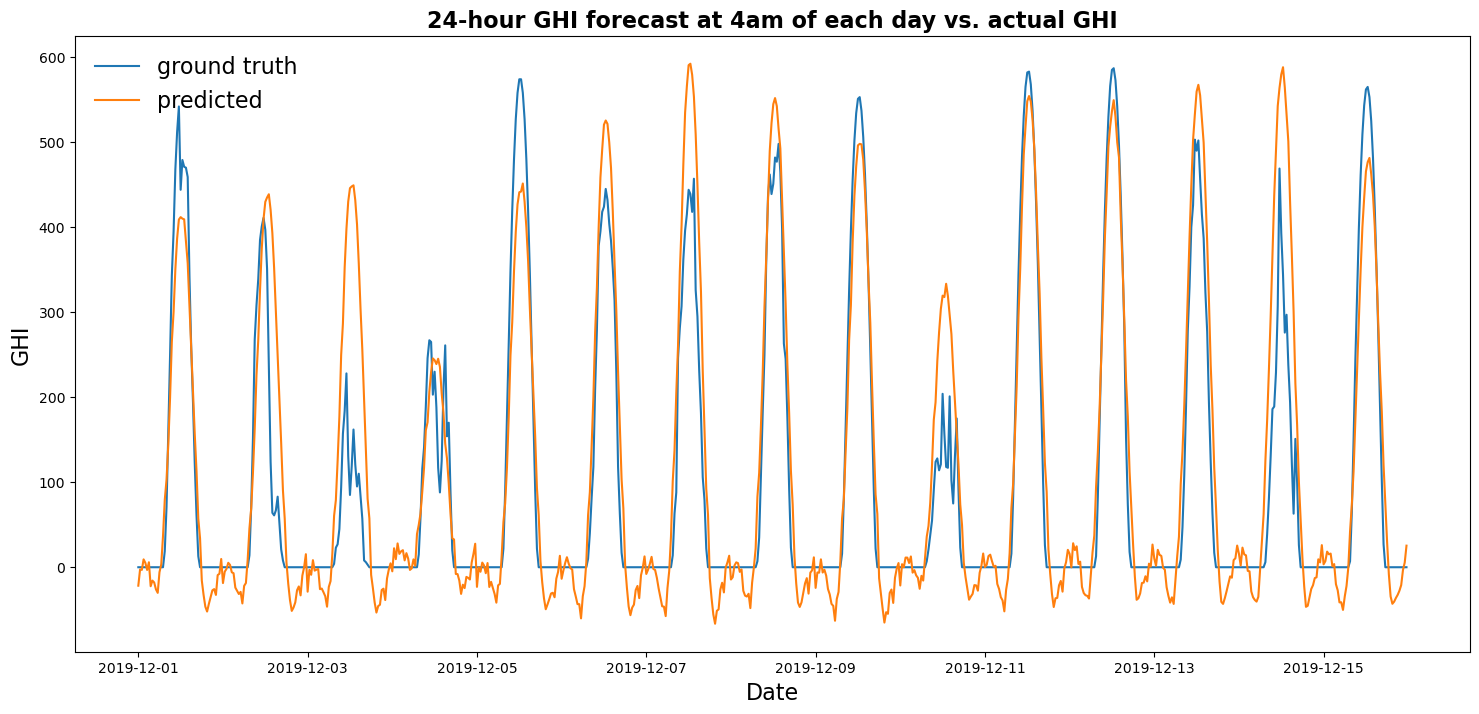

In [90]:
preds_l, test_l = [], []
x = 0
day_start, day_stop = 130, 145
for i in range(day_start, day_stop):
    test_l += list(test_y_ghi[i*48+x,:])
    preds_l += list(preds_test_ghi[i*48+x,:])

#get times
idx_start, idx_stop = (1300 + day_start)*48, (1300 + day_stop)*48
timestamps = df['datetime'][idx_start:idx_stop]
ts = pd.to_datetime(timestamps)

plt.figure(figsize=(18, 8))
plt.plot(ts,test_l, label='ground truth')
plt.plot(ts,preds_l, label='predicted')
plt.xlabel('Date', fontsize=16)
plt.ylabel('GHI', fontsize=16)
plt.title('24-hour GHI forecast at 4am of each day vs. actual GHI', fontweight='bold', fontsize=16)
plt.savefig('../figures/GHI_RNN_m1.png')
plt.legend(frameon=False, fontsize=16);

That looks alright! There is a strange 'second peak' around midnight, but that won't affect our model because ultimately we only care about time intervals where the sun is up.

In order to evaluate our model, we will only use points where the solar zenith angle is above 90.

Filtering these points in the y data is not trivial, because of the way the data is split up into time sequences. So I will have to write a function that creates a mask to easily filter the appropriate timesteps.

In [95]:
def filter_sz(sz, train_y, test_y, n_steps_in):
    """
    Given an input series of solar zenith angle, the train and test y data, and n_steps_in (number of timesteps used to forecast), 
    create boolean arrays in the same shapes as train_y and test_y, which can be used to filter out all datapoints where the sun is down
    (= solar zenith angle below 90 degrees)
    """
    
    #find all indexes where the solar zenith angle is above 90 in the OG dataframe
    sz_mask = np.where(df['Solar Zenith Angle'] < 90, 1, 0)
    train_y_mask = np.zeros(train_y.shape)
    test_y_mask = np.zeros(test_y.shape)
    n_steps_out = train_y.shape[1] #number of timesteps forecasted
    split_idx = train_y.shape[0] #index of split between train and test
    
    #now loop over each batch in train_y and make a mask
    for i in range(train_y.shape[0]):
        start = i + n_steps_in
        stop = i + n_steps_in + n_steps_out
        train_y_mask[i,:] = sz_mask[start:stop]
    for j in range(test_y.shape[0]):
        #print(j)
        start = j + n_steps_in + split_idx -1
        stop = j + n_steps_in + n_steps_out + split_idx -1
        try:
            test_y_mask[j,:] = sz_mask[start:stop]
        except:
            print(j, start, stop)
    return train_y_mask.astype(dtype=bool), test_y_mask.astype(dtype=bool)

In [97]:
train_y_mask, test_y_mask = filter_sz(df['Solar Zenith Angle'], train_y, test_y, n_steps_in)

In [98]:
train_y_filt = train_y[train_y_mask]
test_y_filt = test_y[test_y_mask]
preds_train_filt = preds_train[train_y_mask]
preds_test_filt = preds_test[test_y_mask]

and transformed back to GHI values

In [99]:
test_y_ghi_filt = test_y_ghi[test_y_mask]
train_y_ghi_filt = train_y_ghi[train_y_mask]
preds_train_ghi_filt = preds_train_ghi[train_y_mask]
preds_test_ghi_filt = preds_test_ghi[test_y_mask]

R2 score on the filtered train and test data:

In [100]:
r2_score(train_y_filt, preds_train_filt), r2_score(test_y_filt, preds_test_filt)

(0.8664208620282252, 0.8409668071465745)

In [101]:
mean_squared_error(train_y_ghi_filt, preds_train_ghi_filt, squared=False), mean_squared_error(test_y_ghi_filt, preds_test_ghi_filt, squared=False)

(112.98337039450362, 119.18338455411008)

In [102]:
mean_absolute_error(train_y_ghi_filt, preds_train_ghi_filt), mean_absolute_error(test_y_ghi_filt, preds_test_ghi_filt)

(77.37482861774306, 78.28380657026686)

## RNN with Polynomial Feature Expansion

In [103]:
pf = PolynomialFeatures()
data_pf = pf.fit_transform(df[num_features])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(data_pf)

ss_y = StandardScaler()
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

In [104]:
# choose a number of time steps 
n_steps_in, n_steps_out = 192, 48
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

In [105]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 65), (62400, 48), (25058, 192, 65), (25058, 48))

In [110]:
lstm_model_pf = Sequential()
lstm_model_pf.add(LSTM(32,return_sequences=True, input_shape=(n_steps_in, nr_features)))
lstm_model.add(Dropout(0.03))
lstm_model_pf.add(LSTM(16))

lstm_model_pf.add(Dense(n_steps_out))

In [111]:
#optimizer learning rate
opt = Nadam(learning_rate=0.001)
es = EarlyStopping(patience=5)
lstm_model_pf.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [112]:
history_pf = lstm_model_pf.fit(train_X , train_y, batch_size=1200, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
52/52 [==============================] - 32s 555ms/step - loss: 0.8838 - r_square: 0.1257 - val_loss: 0.6660 - val_r_square: 0.3189
Epoch 2/90
52/52 [==============================] - 22s 431ms/step - loss: 0.5265 - r_square: 0.4791 - val_loss: 0.3684 - val_r_square: 0.6233
Epoch 3/90
52/52 [==============================] - 23s 440ms/step - loss: 0.3285 - r_square: 0.6751 - val_loss: 0.2660 - val_r_square: 0.7280
Epoch 4/90
52/52 [==============================] - 22s 416ms/step - loss: 0.2553 - r_square: 0.7474 - val_loss: 0.2097 - val_r_square: 0.7856
Epoch 5/90
52/52 [==============================] - 23s 439ms/step - loss: 0.2041 - r_square: 0.7981 - val_loss: 0.1649 - val_r_square: 0.8314
Epoch 6/90
52/52 [==============================] - 22s 432ms/step - loss: 0.1641 - r_square: 0.8377 - val_loss: 0.1341 - val_r_square: 0.8628
Epoch 7/90
52/52 [==============================] - 23s 451ms/step - loss: 0.1365 - r_square: 0.8650 - val_loss: 0.1138 - val_r_square: 0.8836

In [113]:
preds_train = lstm_model_pf.predict(train_X)
preds_test = lstm_model_pf.predict(test_X)

784/784 [==============================] - 15s 18ms/step


In [114]:
test_y_ghi = ss_y.inverse_transform(test_y)
preds_test_ghi = ss_y.inverse_transform(preds_test)
train_y_ghi = ss_y.inverse_transform(train_y)
preds_train_ghi = ss_y.inverse_transform(preds_train)

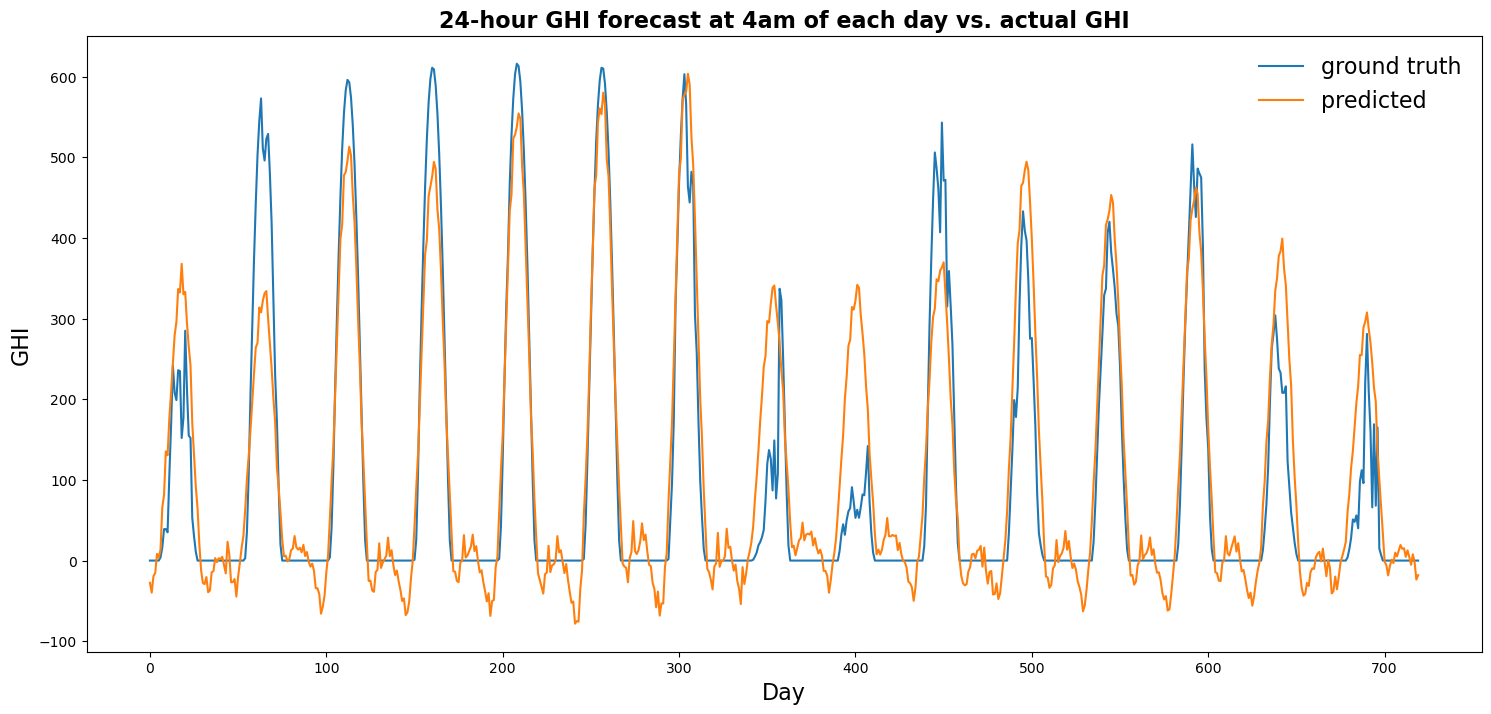

In [115]:
preds_l, test_l = [], []
x = 8 #8 timesteps after midnight, so forecast at 4am
for i in range(115,130):
    test_l += list(test_y_ghi[i*48+x,:])
    preds_l += list(preds_test_ghi[i*48+x,:])
    
#get times
idx_start, idx_stop = (1300 + day_start)*48, (1300 + day_stop)*48
timestamps = df['datetime'][idx_start:idx_stop]
ts = pd.to_datetime(timestamps)

plt.figure(figsize=(18, 8))
plt.plot(test_l, label='ground truth')
plt.plot(preds_l, label='predicted')
plt.xlabel('Day', fontsize=16)
plt.ylabel('GHI', fontsize=16)
plt.title('24-hour GHI forecast at 4am of each day vs. actual GHI', fontweight='bold', fontsize=16)
plt.savefig('../figures/GHI_RNN_m2.png')
plt.legend(frameon=False,fontsize=16)

The feature expansion model does not seem to work significantly better.

Let's evaluate the score for solar zenith angles under 90

In [117]:
train_y_mask, test_y_mask = filter_sz(df['Solar Zenith Angle'], train_y, test_y, n_steps_in)

In [118]:
train_y_filt = train_y[train_y_mask]
test_y_filt = test_y[test_y_mask]
preds_train_filt = preds_train[train_y_mask]
preds_test_filt = preds_test[test_y_mask]

In [119]:
test_y_ghi_filt = test_y_ghi[test_y_mask]
train_y_ghi_filt = train_y_ghi[train_y_mask]
preds_train_ghi_filt = preds_train_ghi[train_y_mask]
preds_test_ghi_filt = preds_test_ghi[test_y_mask]

In [120]:
r2_score(train_y_filt, preds_train_filt), r2_score(test_y_filt, preds_test_filt)

(0.8749798433239235, 0.8489711772337196)

In [121]:
mean_squared_error(train_y_ghi_filt, preds_train_ghi_filt, squared=False), mean_squared_error(test_y_ghi_filt, preds_test_ghi_filt, squared=False)

(109.30379155035013, 116.14532744000856)

In [122]:
mean_absolute_error(train_y_ghi_filt, preds_train_ghi_filt), mean_absolute_error(test_y_ghi_filt, preds_test_ghi_filt)

(73.93369256835949, 77.53361829574784)

Overall, this model seems to perform marginally better.